Testing with a_Mach = 6.752e-11 m/s^2 (H0=65.5, Factor=3pi)
Calculating orbital parameters...
Mean Newtonian Eccentricity: 2.16
Mean WILL Eccentricity:      0.04
Unstable Orbits (e > 0.5) in Newtonian: 78.0%
Unstable Orbits (e > 0.5) in WILL:      10.0%


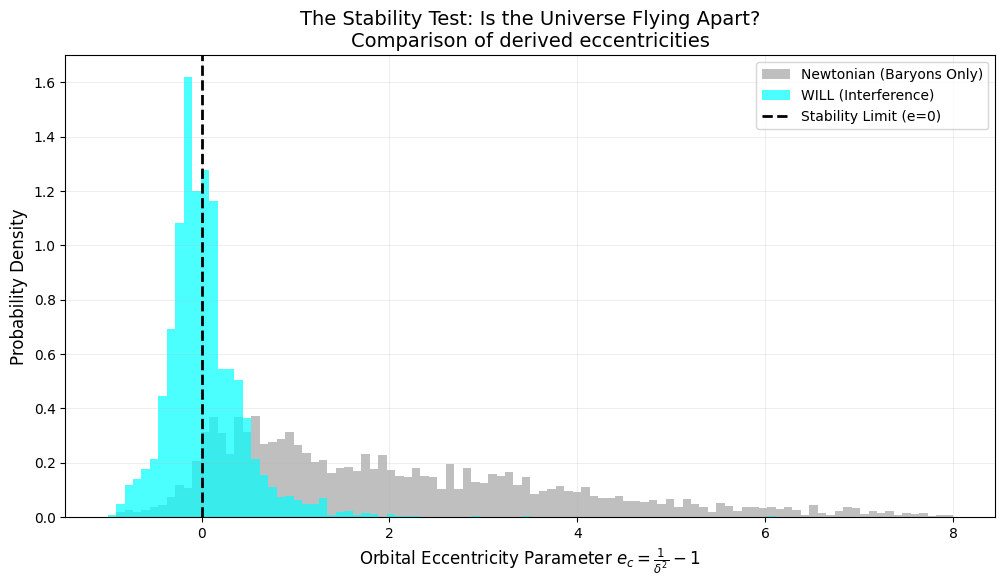

In [1]:
# ==============================================================================
# WILL ECCENTRICITY TEST: STABILITY ANALYSIS
# Compares the orbital stability (eccentricity) of galaxies in Newtonian vs WILL frameworks.
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests, io

# --- 1. CONFIGURATION ---
H0 = 65.5
C_MS = 299792458.0
MPC_TO_M = 3.08567758e22
KPC_TO_M = 3.08567758e19

# Fundamental Acceleration (Step 3 Derivation)
# a_Mach = c * H0 / 3pi
H0_s = (H0 * 1000) / MPC_TO_M
A_MACH = (C_MS * H0_s) / (3 * np.pi)

print(f"Testing with a_Mach = {A_MACH:.3e} m/s^2 (H0={H0}, Factor=3pi)")

# --- 2. DATA LOADING ---
def load_data():
    print("Downloading SPARC data...")
    url_t1 = "https://raw.githubusercontent.com/AntonRize/WILL/refs/heads/main/SPARC%20DATA/table1.dat"
    url_t2 = "https://raw.githubusercontent.com/AntonRize/WILL/refs/heads/main/SPARC%20DATA/table2.dat"

    r1 = requests.get(url_t1); r1.raise_for_status()
    t1 = pd.read_fwf(io.BytesIO(r1.content), colspecs=[(0,11), (30,34), (113,114)], header=None, names=["Name", "Inc", "Qual"])
    t1["Inc"] = pd.to_numeric(t1["Inc"], errors="coerce")
    t1["Qual"] = pd.to_numeric(t1["Qual"], errors="coerce")

    r2 = requests.get(url_t2); r2.raise_for_status()
    t2 = pd.read_fwf(io.BytesIO(r2.content), colspecs=[(0,11), (19,25), (26,32), (33,38), (39,45), (46,52), (53,59)], header=None, names=["Name", "Rad", "Vobs", "e_Vobs", "Vgas", "Vdisk", "Vbul"])
    for c in ["Rad", "Vobs", "e_Vobs", "Vgas", "Vdisk", "Vbul"]: t2[c] = pd.to_numeric(t2[c], errors="coerce")
    t2 = t2.dropna(subset=["Name", "Rad", "Vobs"])
    t2 = t2[(t2["Rad"] > 0) & (t2["Vobs"] > 0)]
    return t1, t2

# --- 3. PHYSICS ENGINE ---
def calculate_eccentricity(t1, t2):
    ecc_newton = []
    ecc_will = []

    print("Calculating orbital parameters...")

    # We use a fixed Y* for fairness (Mean value from previous test)
    # Or we can just sum raw components if we assume standard M/L
    Y_DISK = 0.5
    Y_BUL = 0.7

    for gal in t1["Name"].unique():
        props = t1[t1["Name"] == gal]
        if len(props) == 0: continue
        if props.iloc[0]["Inc"] < 30: continue # Skip face-on

        group = t2[t2["Name"] == gal]
        if len(group) == 0: continue

        # 1. Baryonic Velocity (Newtonian Potential Proxy)
        v_bar_sq = np.abs(group['Vgas'])*group['Vgas'] + Y_DISK*np.abs(group['Vdisk'])*group['Vdisk'] + Y_BUL*np.abs(group['Vbul'])*group['Vbul']
        v_bar_sq = np.maximum(v_bar_sq, 0) # Safety
        v_bar = np.sqrt(v_bar_sq)

        # 2. Observed Velocity (The Demand)
        v_obs = group['Vobs']

        # 3. WILL Prediction (Interference Potential Proxy)
        # g = V^2 / r -> V = sqrt(g * r)
        # g_will = g_bar + sqrt(g_bar * a_mach)

        # Calculate g_bar
        r_meters = group['Rad'] * KPC_TO_M
        conv_vel = 1000.0 # km/s to m/s
        g_bar = (v_bar * conv_vel)**2 / r_meters

        # Apply Interference Law
        g_will = g_bar + np.sqrt(g_bar * A_MACH)
        v_will = np.sqrt(g_will * r_meters) / 1000.0 # back to km/s

        # 4. Calculate Closure Factors (Delta)
        # Delta = V_potential / V_kinetic_demand

        # Newtonian Case: Potential is Baryonic only
        # Avoid division by zero
        mask = (v_obs > 10) & (v_bar > 0)

        # Newtonian Delta
        delta_N = v_bar[mask] / v_obs[mask]

        # WILL Delta (Potential is Interference Field)
        delta_W = v_will[mask] / v_obs[mask]

        # 5. Calculate Eccentricity
        # Formula: e = (1 / delta^2) - 1
        # If delta < 1 (Velocity too high), e > 0 (Elliptical/Hyperbolic)
        # If delta = 1, e = 0 (Circular)

        e_N = (1.0 / delta_N**2) - 1.0
        e_W = (1.0 / delta_W**2) - 1.0

        ecc_newton.extend(e_N)
        ecc_will.extend(e_W)

    return np.array(ecc_newton), np.array(ecc_will)

# --- 4. VISUALIZATION ---
def plot_results(e_N, e_W):
    plt.figure(figsize=(12, 6), dpi=100)

    # Filter for plotting (remove extreme outliers for readability)
    # We want to see the distribution around 0
    e_N = e_N[e_N < 10]
    e_W = e_W[e_W < 10]
    e_W = e_W[e_W > -2] # Should not happen physically but good for safety

    # Histogram
    plt.hist(e_N, bins=100, range=(-1, 8), density=True, alpha=0.5, color='gray', label='Newtonian (Baryons Only)')
    plt.hist(e_W, bins=100, range=(-1, 8), density=True, alpha=0.7, color='cyan', label='WILL (Interference)')

    # Add vertical line at e=0 (Stability)
    plt.axvline(0, color='k', linestyle='--', linewidth=2, label='Stability Limit (e=0)')

    plt.xlabel(r'Orbital Eccentricity Parameter $e_c = \frac{1}{\delta^2} - 1$', fontsize=12)
    plt.ylabel('Probability Density', fontsize=12)
    plt.title('The Stability Test: Is the Universe Flying Apart?\nComparison of derived eccentricities', fontsize=14)
    plt.legend()
    plt.grid(alpha=0.2)

    # Calculate Stats
    print(f"Mean Newtonian Eccentricity: {np.mean(e_N):.2f}")
    print(f"Mean WILL Eccentricity:      {np.mean(e_W):.2f}")

    # Count unstable orbits (e > 0.5 is significantly non-circular)
    unstable_N = np.sum(e_N > 0.5) / len(e_N) * 100
    unstable_W = np.sum(e_W > 0.5) / len(e_W) * 100
    print(f"Unstable Orbits (e > 0.5) in Newtonian: {unstable_N:.1f}%")
    print(f"Unstable Orbits (e > 0.5) in WILL:      {unstable_W:.1f}%")

    plt.show()

# --- RUN ---
t1, t2 = load_data()
eN, eW = calculate_eccentricity(t1, t2)
plot_results(eN, eW)